In [1]:
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
from tensorflow.keras.layers import Input,Dense,Reshape,Conv2D,Dropout,multiply,Dot,Concatenate,subtract,ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization,LeakyReLU,Flatten
from tensorflow.keras.layers import Conv2DTranspose as Deconv2d
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# from google.colab import files
from keras import backend as K
import smtplib

from sklearn.utils import shuffle

In [4]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from tensorflow.keras.preprocessing.image import img_to_array


In [5]:
# to get the files in proper order
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 128
color_img = []
path = r'C:\Users\Admin\Downloads\DAT_pj\color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
        if i == '2200.jpg':
            break
        else:
            img = cv2.imread(path + '/'+i,1)
            # open cv reads images in BGR format so we have to convert it to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #resizing image
            img = cv2.resize(img, (SIZE, SIZE))
            img = img.astype('float32') / 255.0
            color_img.append(img_to_array(img))


gray_img = []
path = r'C:\Users\Admin\Downloads\DAT_pj\gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
         if i == '2200.jpg':
            break
         else:
            img = cv2.imread(path + '/'+i,1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #resizing image
            img = cv2.resize(img, (SIZE, SIZE))
            img = img.astype('float32') / 255.0
            gray_img.append(img_to_array(img))

100%|██████████| 12868/12868 [00:58<00:00, 219.66it/s]


# Show Images

In [6]:
color_dataset=tf.data.Dataset.from_tensor_slices(np.array(color_img[:1000])).batch(16)
gray_dataset=tf.data.Dataset.from_tensor_slices(np.array(gray_img[:1000])).batch(16)

color_dataset_t=tf.data.Dataset.from_tensor_slices(np.array(color_img[1000:])).batch(4)
gray_dataset_t=tf.data.Dataset.from_tensor_slices(np.array(gray_img[1000:])).batch(4)

In [7]:
example_color = next(iter(color_dataset))
example_gray = next(iter(gray_dataset))

In [8]:
def plot_images(a = 2):

    for i in range(a):
        plt.figure(figsize = (10,10))
        plt.subplot(121)
        plt.title('color')
        plt.imshow(example_color[i] )

        plt.subplot(122)
        plt.title('gray')
        plt.imshow(example_gray[i])
        plt.show()

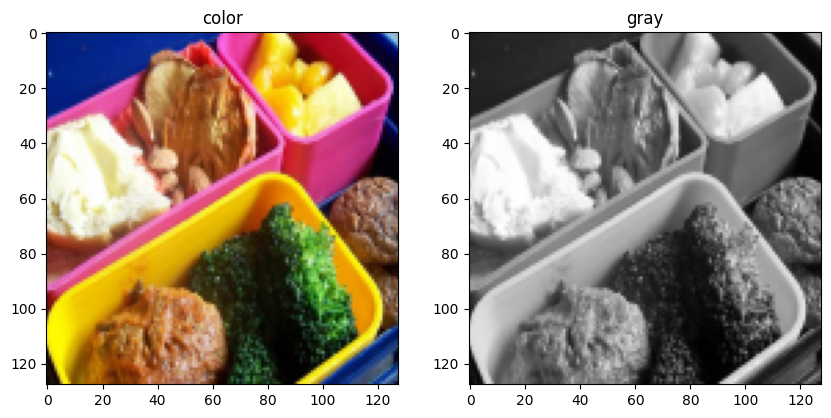

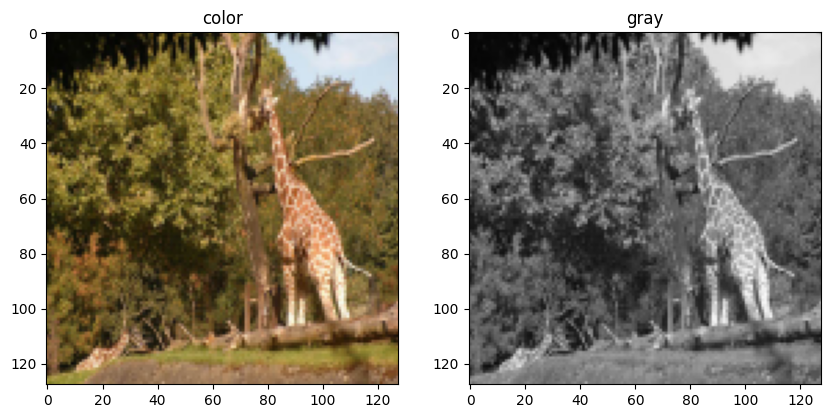

In [9]:
plot_images(2)

# Modeling

In [13]:
def downsample(filters, size, apply_batchnorm=True):
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer='he_normal', use_bias=not apply_batchnorm))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())
    return result


def upsample(filters, size, apply_dropout=False):

  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())
  return result

# Generator

In [14]:
import tensorflow as tf

# Giả sử các hàm downsample và upsample đã được định nghĩa
# downsample(filters, size, apply_batchnorm=True)
# upsample(filters, size, apply_dropout=False)

def Generator():
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # ✅ Downsampling (giảm 1 tầng và số filters để giảm tham số)
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (64, 64, 64)
        downsample(128, 4),  # (32, 32, 128)
        downsample(256, 4),  # (16, 16, 256)
        downsample(384, 4),  # (8, 8, 384)  ✅ Giảm filters từ 512 -> 384
        downsample(384, 4),  # (4, 4, 384)
        downsample(512, 4),  # (2, 2, 512)  ✅ Giữ 512 ở mức thấp nhất
    ]

    # ✅ Upsampling (giảm filters ở các tầng trên)
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (4, 4, 512)
        upsample(384, 4, apply_dropout=True),  # (8, 8, 384)  ✅ Giảm filters
        upsample(256, 4),  # (16, 16, 256)
        upsample(128, 4),  # (32, 32, 128)
        upsample(64, 4),   # (64, 64, 64)
        upsample(32, 4),   # (128, 128, 32)
    ]

    # ✅ Dùng SeparableConv2D thay cho Conv2D để giảm tham số
    last = tf.keras.layers.SeparableConv2D(3, kernel_size=3, strides=1, padding='same', activation='tanh')

    x = inputs
    skips = []

    # Downsampling với skip connections
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])  # Bỏ tầng cuối cùng

    # Upsampling với skip connections
    for up, skip in zip(up_stack[:-1], skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    # Tầng upsample cuối cùng không có skip connection
    x = up_stack[-1](x)

    # Tầng đầu ra
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

# Kiểm tra mô hình
generator = Generator()
generator.summary()


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 64, 64,    │      3,136 │ input_layer_1[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 32, 32,    │    131,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 16, 16,    │    525,312 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 8, 8, 384) │  1,574,400 │ sequential_2[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 4, 4, 384) │  2,360,832 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 2, 2, 512) │  3,147,776 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 4, 4, 512) │  4,196,352 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4, 4, 896) │          0 │ sequential_6[0][… │
│ (Concatenate)       │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 8, 8, 384) │  5,506,560 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 8, 8, 768) │          0 │ sequential_7[0][… │
│ (Concatenate)       │                   │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 16, 16,    │  3,146,752 │ concatenate_1[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 16, 16,    │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 512)              │            │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 32, 32,    │  1,049,088 │ concatenate_2[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 32, 32,    │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 256)              │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 64, 64,    │    262,400 │ concatenate_3[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 64, 64,    │          0 │ sequential_10[0]

 Total params: 21,970,243 (83.81 MB)

 Trainable params: 21,964,163 (83.79 MB)

 Non-trainable params: 6,080 (23.75 KB)

# Discriminator

In [61]:
import tensorflow as tf

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[128, 128, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[128, 128, 3], name='target_image')

    x = tf.keras.layers.Concatenate()([inp, tar])  # (bs, 128, 128, 6)

    down1 = downsample(64, 4, apply_batchnorm=False)(x)   # (bs, 64, 64, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 32, 32, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 16, 16, 256)
    down4 = downsample(512, 4)(down3)  # (bs, 8, 8, 512)
    down5 = downsample(512, 4)(down4)  # (bs, 4, 4, 512)
    down6 = downsample(512, 4)(down5)  # (bs, 2, 2, 512) ✅

    conv = tf.keras.layers.Conv2D(512, 4, strides=1, padding='same',
                                  kernel_initializer=initializer, use_bias=False)(down6)  # (bs, 2, 2, 512)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    last = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same',
                                  kernel_initializer=initializer)(leaky_relu)  # (bs, 2, 2, 1) ✅

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

# Test model
discriminator = Discriminator()
discriminator.summary()


Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 target_image (InputLayer)      [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_40 (Concatenate)   (None, 128, 128, 6)  0           ['input_image[0][0]',            
                                                                  'target_image[0][0]']    

In [62]:
disc = Discriminator()
sample_input = tf.random.normal([1, 128, 128, 3])
sample_target = tf.random.normal([1, 128, 128, 3])
output = disc([sample_input, sample_target])
print(f"Discriminator output shape: {output.shape}")


Discriminator output shape: (1, 2, 2, 1)


# Check Loss 

In [64]:
genLoss=[]
discLoss=[]

In [65]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)  # Giữ nguyên
discriminator_optimizer = tf.keras.optimizers.Adam(7e-5, beta_1=0.5, weight_decay=1e-4)

LAMBDA = 150

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)
  genLoss.append(total_gen_loss)

  return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss
  discLoss.append(total_disc_loss)

  return total_disc_loss

# Training Method

In [66]:
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        
        # Đảm bảo gen_output có shape giống target
        gen_output = tf.image.resize(gen_output, (128, 128))
        
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss  # ✅ Trả về loss



In [67]:
# Tạo dataset đúng định dạng
def prepare_dataset(color_imgs, gray_imgs, batch_size=16):
    color_imgs = np.array(color_imgs)
    gray_imgs = np.array(gray_imgs)
    
    dataset = tf.data.Dataset.from_tensor_slices((gray_imgs, color_imgs))
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Sử dụng dataset đúng
train_dataset = prepare_dataset(color_img[:1000], gray_img[:1000])
test_dataset = prepare_dataset(color_img[1000:], gray_img[1000:], batch_size=4)

# Chạy training loop
epochs = 1
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for input_image, target in train_dataset:
        train_step(input_image, target, epoch)


Epoch 1/1


# Fitting Method

In [9]:
import tensorflow as tf
print(tf.__version__)


2.18.0


In [69]:
import time

def fit(train_ds, epochs):
    history = {'gen_loss': [], 'gen_gan_loss': [], 'gen_l1_loss': [], 'disc_loss': []}

    for epoch in range(epochs):
        start = time.time()
        total_gen_loss, total_gan_loss, total_l1_loss, total_disc_loss = 0, 0, 0, 0
        num_batches = 0

        print("Epoch:", epoch+1)
        for n, (input_image, target) in train_ds.enumerate():
            gen_loss, gan_loss, l1_loss, disc_loss = train_step(input_image, target, epoch)

            total_gen_loss += gen_loss.numpy()
            total_gan_loss += gan_loss.numpy()
            total_l1_loss += l1_loss.numpy()
            total_disc_loss += disc_loss.numpy()
            num_batches += 1

        avg_gen_loss = total_gen_loss / num_batches
        avg_gan_loss = total_gan_loss / num_batches
        avg_l1_loss = total_l1_loss / num_batches
        avg_disc_loss = total_disc_loss / num_batches

        history['gen_loss'].append(avg_gen_loss)
        history['gen_gan_loss'].append(avg_gan_loss)
        history['gen_l1_loss'].append(avg_l1_loss)
        history['disc_loss'].append(avg_disc_loss)

        print(f"Epoch {epoch+1}: Gen Loss: {avg_gen_loss:.4f}, GAN Loss: {avg_gan_loss:.4f}, L1 Loss: {avg_l1_loss:.4f}, Disc Loss: {avg_disc_loss:.4f}")
        print(f"Time taken for epoch {epoch+1} is {time.time()-start:.2f} sec\n")

        # Lưu trọng số mỗi 5 epoch
        if (epoch + 1) % 5 == 0:
            generator.save_weights(f'generator_epoch_{epoch+1}.weights.h5')
            discriminator.save_weights(f'discriminator_epoch_{epoch+1}.weights.h5')
            print(f"✅ Đã lưu trọng số tại Epoch {epoch+1}")

    return history


# Fitting in 50 epochs

In [70]:
gray_dataset = tf.data.Dataset.from_tensor_slices(gray_img)
color_dataset = tf.data.Dataset.from_tensor_slices(color_img)


In [71]:
BATCH_SIZE = 16  # Chọn batch size phù hợp (VD: 16, 32,...)
train_dataset = tf.data.Dataset.zip((
    gray_dataset.batch(BATCH_SIZE),
    color_dataset.batch(BATCH_SIZE)
)).shuffle(1000)  # Shuffle để tránh overfitting

In [72]:
for input_image, target in train_dataset.take(1):  # Lấy 1 batch đầu tiên
    print("Input shape:", input_image.shape)
    print("Target shape:", target.shape)


Input shape: (16, 128, 128, 3)
Target shape: (16, 128, 128, 3)


In [93]:
hist = fit(train_dataset, epochs=20)
print(hist)  # Xem loss từng epoch


Epoch: 1
Epoch 1: Gen Loss: 9.3787, GAN Loss: 1.0719, L1 Loss: 0.0554, Disc Loss: 1.1094
Time taken for epoch 1 is 2203.75 sec

Epoch: 2
Epoch 2: Gen Loss: 9.2351, GAN Loss: 1.0734, L1 Loss: 0.0544, Disc Loss: 1.1039
Time taken for epoch 2 is 2196.92 sec

Epoch: 3
Epoch 3: Gen Loss: 9.1056, GAN Loss: 1.0639, L1 Loss: 0.0536, Disc Loss: 1.1077
Time taken for epoch 3 is 2200.26 sec

Epoch: 4
Epoch 4: Gen Loss: 8.9338, GAN Loss: 1.0514, L1 Loss: 0.0525, Disc Loss: 1.1085
Time taken for epoch 4 is 2205.12 sec

Epoch: 5
Epoch 5: Gen Loss: 8.8296, GAN Loss: 1.0599, L1 Loss: 0.0518, Disc Loss: 1.1193
Time taken for epoch 5 is 2191.84 sec

✅ Đã lưu trọng số tại Epoch 5
Epoch: 6
Epoch 6: Gen Loss: 8.6582, GAN Loss: 1.0726, L1 Loss: 0.0506, Disc Loss: 1.1042
Time taken for epoch 6 is 2184.97 sec

Epoch: 7
Epoch 7: Gen Loss: 8.5942, GAN Loss: 1.0821, L1 Loss: 0.0501, Disc Loss: 1.0957
Time taken for epoch 7 is 2208.02 sec

Epoch: 8
Epoch 8: Gen Loss: 8.4434, GAN Loss: 1.0897, L1 Loss: 0.0490, Dis

In [94]:
generator.save_weights(f'generator_epoch_{epoch+1}.weights.h5')
discriminator.save_weights(f'discriminator_epoch_{epoch+1}.weights.h5')


In [ ]:
# !pip install seaborn


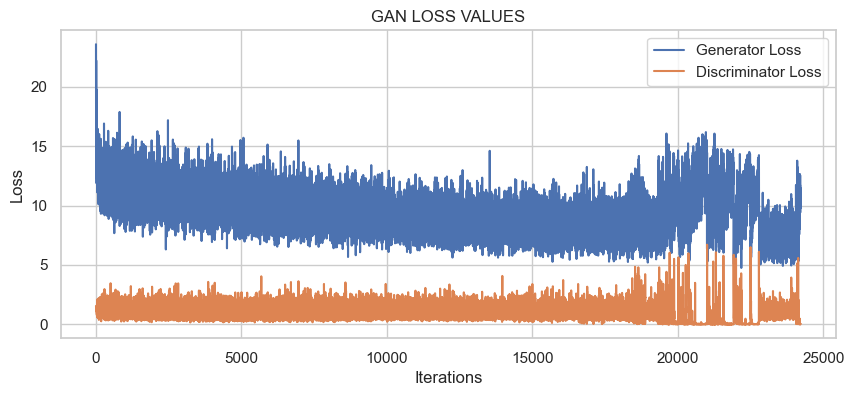

In [95]:
import seaborn as sns
sns.set(style='whitegrid')
plt.figure(figsize=(10,4))
plt.plot(genLoss, label="Generator Loss")
plt.plot(discLoss, label="Discriminator Loss")
plt.title("GAN LOSS VALUES")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Trying on new image out of Datasets

In [6]:
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

In [7]:
SIZE = 128
img2 = cv2.imread(r"download.jpg").astype("float32")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
# img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
try:
    img2 = img2.reshape(1,SIZE,SIZE,3)
except:
    img2 = cv2.resize(img2,(SIZE,SIZE))
    img2 = img2.reshape(1,SIZE,SIZE,3)

In [8]:
img2.shape

(1, 128, 128, 3)

In [9]:
img2[0] = img2[0]/255.0

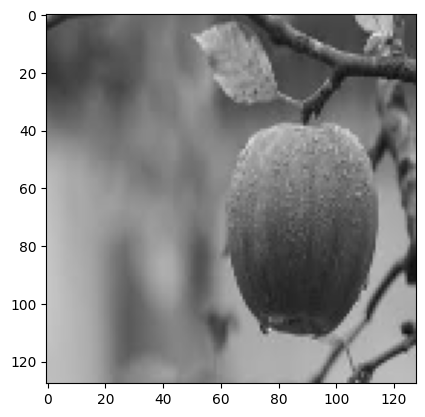

In [10]:
plt.imshow(img2[0])

In [18]:
generator.load_weights(r"generator_epoch_30.weights.h5")

In [19]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    print(test_input[0].shape)
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2016761..0.98765653].


(128, 128, 3)
(128, 128, 3)
(128, 128, 3)


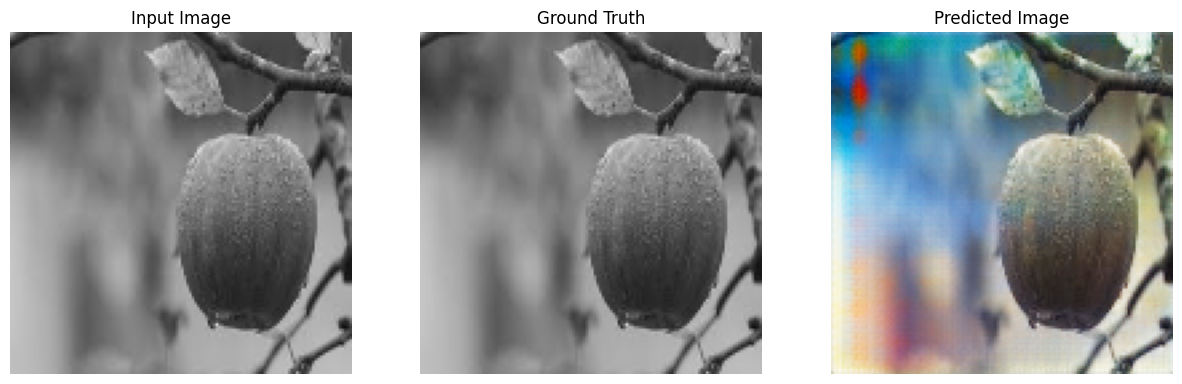

In [20]:
Pred=generate_images(generator,img2, img2)

This is the image after Colorizing

# Saving and Load Model

In [120]:
model_Generator_json=generator.to_json()
model_discriminator_json=discriminator.to_json()


In [121]:
import json

# Lưu cấu trúc mô hình dưới dạng JSON
model_Generator_json = generator.to_json()
with open("modelGenerator.json", "w") as json_file:
    json.dump(model_Generator_json, json_file)  # Dùng json.dump thay vì write

# Lưu trọng số của mô hình
generator.save_weights("modelGen.weights.h5")


print("Saved model to disk")


Saved model to disk


In [122]:
with open('modelDescriminator.json','w') as json_file:
  json_file.write(model_discriminator_json)
generator.save_weights("modelDis.weights.h5")

print('saved model  Dis to disk')

saved model  Dis to disk
